In [47]:
import os
import sys

path = os.getcwd()
while os.path.basename(os.path.normpath(path)) != 'roman-pandeia':
        path = os.path.dirname(path)
repo_path = path
if repo_path not in sys.path:
    sys.path.append(repo_path)

In [48]:
import time
from datetime import timedelta, datetime
from pprint import pprint
import numpy as np
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'

from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy import stats
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from regions.core import PixCoord
from regions.shapes.circle import CirclePixelRegion
from photutils.detection import DAOStarFinder

from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
import lenstronomy.Util.util as util
from lenstronomy.Util import kernel_util
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.pixel_grid import PixelGrid

from regions import PixCoord, EllipsePixelRegion

from utils import csv_utils, psf_utils, utils

Import data: grade A, IR, source and deflector spectroscopic redshifts

In [49]:
csv_filepath = os.path.join(repo_path, 'data', 'SLACS', 'SLACS.csv')
dataset_dict_list = csv_utils.csv_to_dict_list(csv_filepath)

In [50]:
data_set_name = 'J9OP04010'

# J9OP02010 - fine
# J9EM25AFQ - fine
# J9OP04010 - weirdness around arcs but eh
# J9OP05010 - fine
# J9EM0SEEQ - finds bright spots instead of long arc
# J9OP06010 - doesn't fit well

dataset = [d for d in dataset_dict_list if d.get('data_set_name') == data_set_name][0]

pprint(dataset)

ra, dec = float(dataset.get('ra')), float(dataset.get('dec'))

{'AI': '0.15',
 'Fiber': '614',
 'Imag': '18.04',
 'L(V555)': '55.8',
 'Le2/LdV': '0.317',
 'Lens': 'A',
 'MJD': '52295',
 'Mph': 'E',
 'Mul': 'S',
 'Name': 'J0252+0039',
 'PA': '97.2',
 'Plate': '807',
 'Re': '1.39',
 'SDSS': '025245.21+003958.4',
 '_DE': '0.66622',
 '_RA': '43.18837',
 'actual_duration': '2088.0',
 'aper': 'WFC1',
 'b/a': '0.94',
 'central_wavelength': '8045.1699',
 'cutout': '',
 'cutout_filepath': '/data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9OP04010.fits',
 'data_set_name': 'J9OP04010',
 'data_uri': 'mast:HST/product/j9op04010_drz.fits',
 'dec': '0.666212458955',
 'e_sigma': '12',
 'filename': 'j9op04010_drz.fits',
 'fits_filepath': '/data/bwedig/roman-pandeia/data/mastDownload/SLACS/j9op04010_drz.fits',
 'instrument': 'ACS   ',
 'n_Imag': 'd',
 'n_Lens': ' ',
 'peak_value': '',
 'preview_name': 'J9OP04010',
 'ra': '43.18833963809',
 'recno': '9',
 'release_date': '2006-10-03T12:25:49',
 'sigma': '164',
 'spec': 'CLEAR1L;F814W',
 'star

Open `.fits` file

In [51]:
with fits.open(dataset.get('cutout_filepath')) as hdu_list:
    hdu_list.verify()
    hdu_list.info()
    data = hdu_list['PRIMARY'].data
    header = hdu_list['PRIMARY'].header

wcs = WCS(header=hdu_list['PRIMARY'].header)

Filename: /data/bwedig/roman-pandeia/data/cutouts/SLACS/cutout_WFC1_CLEAR1L;F814W_J9OP04010.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      91   (300, 300)   float32   


Take a quick look at the image

/tmp/ipykernel_16827/1022304046.py:4: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(data), origin='lower')


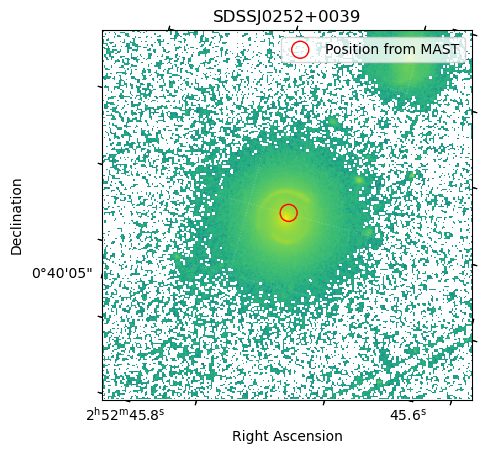

In [52]:
center_pixel_y, center_pixel_x = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)

ax = plt.subplot(projection=wcs)
ax.imshow(np.log10(data), origin='lower')
plt.grid(color='white', ls=':', alpha=0.2)
plt.scatter(center_pixel_x, center_pixel_y, edgecolor='red', facecolor='none', s=150, label='Position from MAST')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title(dataset.get('target_name'))
plt.legend()
plt.show()

Crop down to 5x5 arcseconds

In [53]:
sky_coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
size = u.Quantity((5, 5), u.arcsec)
cutout_obj = Cutout2D(data, sky_coords, size, wcs=wcs)

# overwrite data and wcs
data = cutout_obj.data
wcs = cutout_obj.wcs

print(cutout_obj.shape)

(100, 100)


/tmp/ipykernel_16827/1022304046.py:4: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(data), origin='lower')


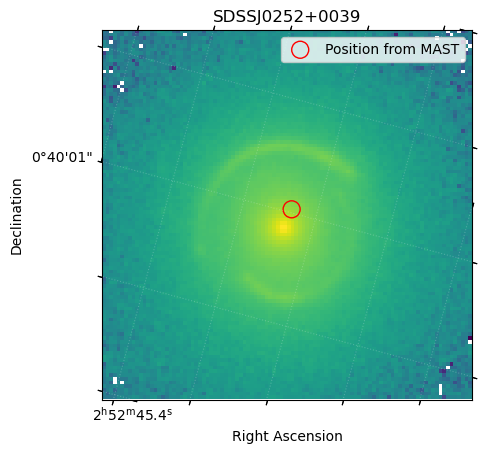

In [54]:
center_pixel_y, center_pixel_x = wcs.all_world2pix(ra, dec, 1, adaptive=False, ra_dec_order=True)

ax = plt.subplot(projection=wcs)
ax.imshow(np.log10(data), origin='lower')
plt.grid(color='white', ls=':', alpha=0.2)
plt.scatter(center_pixel_x, center_pixel_y, edgecolor='red', facecolor='none', s=150, label='Position from MAST')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title(dataset.get('target_name'))
plt.legend()
plt.show()

Calculate the background RMS

Background RMS: 0.016299735266660332


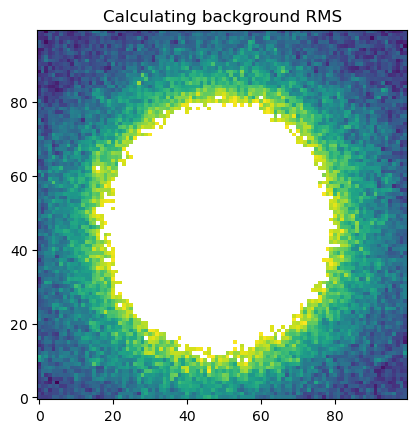

In [55]:
cut_mask = stats.sigma_clip(data, sigma=2, maxiters=5)
rms = np.std(cut_mask)

print('Background RMS: ' + str(rms))

plt.imshow(cut_mask, origin='lower')
plt.title('Calculating background RMS')
plt.show()

Mask any bright spots

(0.04355382, 0.032102592, 0.035326544)
 id xcentroid ycentroid sharpness roundness1 ... npix sky  peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ---- ---- ----- -----
  1     48.51     45.91      0.63       0.00 ...   25 0.00 6.15 17.94 -3.13


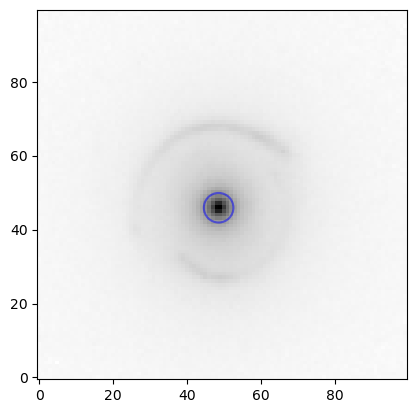

In [56]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0) 
print((mean, median, std)) 

daofind = DAOStarFinder(fwhm=2.0, threshold=5.*std)  
sources = daofind(data - median)  

for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
sources.pprint(max_width=76)  

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

Masked 0 source(s)


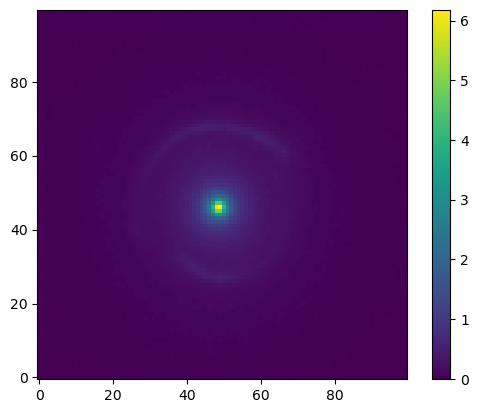

In [57]:
# identify those bright spots well outside of the centered lensing galaxy
num_sources_masked = 0
masks = []
for source in sources:
    if source['xcentroid'] > 60 or source['xcentroid'] < 40 or source['ycentroid'] > 60 or source['ycentroid'] < 40:
        mask_center_x = source['xcentroid']
        mask_center_y = source['ycentroid']

        # build mask
        center = PixCoord(mask_center_x, mask_center_y)
        region = CirclePixelRegion(center, 2.)
        mask = region.to_mask(mode='center')
        data = data - (mask.to_image(data.shape) * data) + (mask.to_image(data.shape) * mean)

        num_sources_masked += 1
print(f'Masked {num_sources_masked} source(s)')

plt.imshow(data)
plt.colorbar()

Pull data from header and calculate transformations

In [58]:
# data specifics
start_time = datetime.fromisoformat(dataset.get('start_time'))
stop_time = datetime.fromisoformat(dataset.get('stop_time'))
background_rms = rms  # background noise per pixel
exp_time = (stop_time - start_time).seconds  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
pixel_scale = float(header.get('D001SCAL'))  # pixel size in arcsec (area per pixel = pixel_scale**2)

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header.get('CD1_1') * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header.get('CD1_2') * 3600
CD2_1 = header.get('CD2_1') * 3600
CD2_2 = header.get('CD2_2') * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# read out pixel size of image
# nx, ny = header.get('NAXIS1'), header.get('NAXIS2')
# but these values are for the original fits file, so use updated values
nx, ny = data.shape
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))

# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

Import PSF `.fits` file

???????????????????????????????????????????????????????????????????????????????? [astropy.io.fits.card]
/tmp/ipykernel_16827/3783038541.py:10: RuntimeWarning: divide by zero encountered in log10
  ax1.matshow(np.log10(psf_data), origin='lower')
/tmp/ipykernel_16827/3783038541.py:10: RuntimeWarning: invalid value encountered in log10
  ax1.matshow(np.log10(psf_data), origin='lower')


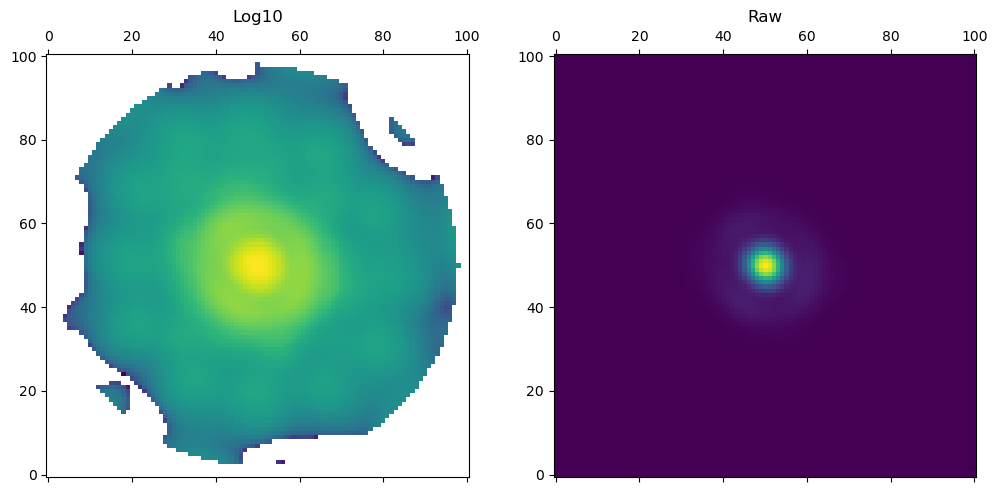

101 (101, 101)


In [59]:
psf_filepath = os.path.join(repo_path, 'psfs', 'PSFSTD_WFC3UV_F814W.fits')

with fits.open(psf_filepath, ignore_missing_end=True) as hdu_list:
    # hdu_list.verify()
    psf_data = hdu_list['PRIMARY'].data[17]  # middle of first chip
    psf_header = hdu_list['PRIMARY'].header

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.matshow(np.log10(psf_data), origin='lower')
ax2.matshow(psf_data, origin='lower')

title1 = 'Log10'
ax1.set_title(title1)
title2 = 'Raw'
ax2.set_title(title2)

plt.show()

# if kernel needs to be cut down, lenstronomy has a method for that
kernel_size = psf_header.get('NAXIS1')  # PSF kernel size (odd number required).
print(kernel_size, psf_data.shape)
kernel_cut = kernel_util.cut_psf(psf_data, kernel_size)
psf_pix_map = kernel_util.degrade_kernel(psf_data - np.min(psf_data), 2)


Pull PSF in to `lenstronomy`

Getting `fwhm` number from [here](https://hst-docs.stsci.edu/wfc3ihb/chapter-6-uvis-imaging-with-wfc3/6-6-uvis-optical-performance)

In [60]:
# kwargs_psf = psf_utils.get_none_kwargs_psf()
# kwargs_psf = psf_utils.get_gaussian_kwargs_psf(fwhm=0.074, pixel_size=pixel_scale, truncation=3)
kwargs_psf = {
    'psf_type':'PIXEL',
    'kernel_point_source': psf_pix_map,
    'point_source_supersampling_factor': 2
}
psf_class = psf_utils.get_psf_class(kwargs_psf)

## Get macrolens model

Prepare `ImageData` class

In [61]:
kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': pix2coord_transform_undistorted,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix), units of arcseconds
               'image_data': data
              }

data_class = ImageData(**kwargs_data)
data_class.update_data(data)

Define guesses (spread and bounds for all parameters). Then, run particle swarm optimization (PSO) to minimize $\chi^2$

In [62]:
# lens params
lens_model_list = ['SIE', 'SHEAR']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append({'theta_E': 1., 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.})
kwargs_lens_sigma.append({'theta_E': 0.5, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_lens.append({'theta_E': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10., 'center_y': -10.})
kwargs_upper_lens.append({'theta_E': 3., 'e1': 0.5, 'e2': 0.5, 'center_x': 10., 'center_y': 10.})

# fixed_lens.append({})
fixed_lens.append({'ra_0': 0., 'dec_0': 0.})
kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.})
kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

# source params
source_model_list = ['SERSIC_ELLIPSE']

fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0, 'amp': 5.})
kwargs_source_sigma.append({'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2, 'amp': 1.})
kwargs_lower_source.append({'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10, 'amp': 5.})
kwargs_upper_source.append({'R_sersic': 10., 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10, 'amp': 10.})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

# lens light params
lens_light_model_list = ['SERSIC_ELLIPSE']

fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0, 'amp': 16})
kwargs_lens_light_sigma.append({'R_sersic': 0.3, 'n_sersic': 1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1, 'amp': 10})
kwargs_lower_lens_light.append({'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10, 'amp': 0})
kwargs_upper_lens_light.append({'R_sersic': 10., 'n_sersic': 5., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10, 'amp': 100})

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                 'lens_light_model': lens_light_params}  # NB add special params here if using them

kwargs_model = {'lens_model_list': lens_model_list,
                'source_light_model_list': source_model_list,
                'lens_light_model_list': lens_light_model_list}

In [63]:
kwargs_likelihood = {'source_marg': False}
kwargs_numerics = {'supersampling_factor': 4, 'supersampling_convolution': False}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
# if you have multiple bands to be modeled simultaneously, you can append them to the multi_band_list

kwargs_data_joint = {'multi_band_list': multi_band_list, 
                     'multi_band_type': 'single-band'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                    }
kwargs_constraints = {'linear_solver': True}  # optional, if 'linear_solver': False, lenstronomy does not apply a linear inversion of the 'amp' parameters during fitting but instead samples them.

Take a look at the initial parameters next to image we're fitting

/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Data/psf.py:126: Warning: Super-sampled point source kernel over-written due to different subsampling size requested.
  warnings.warn("Super-sampled point source kernel over-written due to different subsampling"


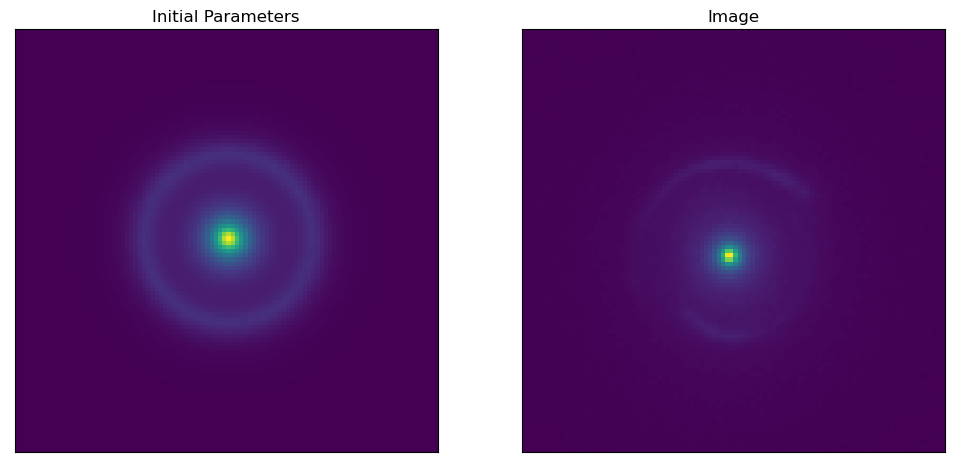

In [64]:
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': pix2coord_transform_undistorted}
pixel_grid = PixelGrid(**kwargs_pixel)

lens_model_class = LensModel(lens_model_list=lens_model_list)
source_model_class = LightModel(light_model_list=source_model_list)
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

imageModel = ImageModel(data_class=pixel_grid,
                        psf_class=psf_class,
                        lens_model_class=lens_model_class,
                        source_model_class=source_model_class,
                        lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens=kwargs_lens_init, kwargs_source=kwargs_source_init,
                             kwargs_lens_light=kwargs_lens_light_init)

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax1.matshow(image_sim, origin='lower')
ax2.imshow(data, origin='lower')

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

title1 = 'Initial Parameters'
ax1.set_title(title1)
title2 = 'Image'
ax2.set_title(title2)

plt.show()

Perform fitting

In [65]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

pso = ['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 200}]
# pso = ['PSO', {'sigma_scale': 1., 'n_particles': 400, 'n_iterations': 400}]
# mcmc = ['MCMC', {'n_burn': 20, 'n_run': 20, 'walkerRatio': 4, 'sigma_scale': .1, 'threads': thread_count}]
mcmc = ['MCMC', {'n_burn': 100, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}]
# mcmc = ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers': 200, 'sigma_scale': .1}]
fitting_kwargs_list = [pso, mcmc]

start_time = time.time()
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
end_time = time.time()
execution_time = round(end_time - start_time)
print(timedelta(seconds=execution_time), 'total time needed for computation')

Computing the PSO ...
PSO: Exception while calling your likelihood function:
  params: [1.348973053615775, -0.044250509670749054, -0.04095807731422507, -0.022523682506254274, 0.011501519273436941, 0.0112097302054468, -0.04120866370803651, 0.2876405689441534, 0.7831738082965933, 0.019990325306068854, -0.028042550203601458, -0.14179586056800814, 0.1537634826791871, 0.4078620084772288, 2.6154155078408827, 0.011049058567303725, -0.01129477064244716, 0.018240130513143354, 0.08373052364975406]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Sampling/Samplers/pso.py", line 446, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Sampling/likelihood.py", line 173, in logL
    return self.log_likelihood(kwargs_return, verbose=verbose)
  File "/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Sampling/likelihood.py", line 201, in log_likelihood
    logL_image = self.image_likelihood.logL(**kwargs_return)
  File "/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Sampling/Likelihoods/image_likelihood.py", line 53, in logL
    logL = self.imSim.likelihood_data_given_model(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps,
  File "/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/ImSim/MultiBand/single_band_multi_model.py", line 112, 

KeyboardInterrupt: 

Plot results of MCMC chain

-1.7382667754553105 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.7382667754553105


/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


/data/bwedig/.conda/envs/lenstronomy/lib/python3.9/site-packages/lenstronomy/Plots/model_band_plot.py:506: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


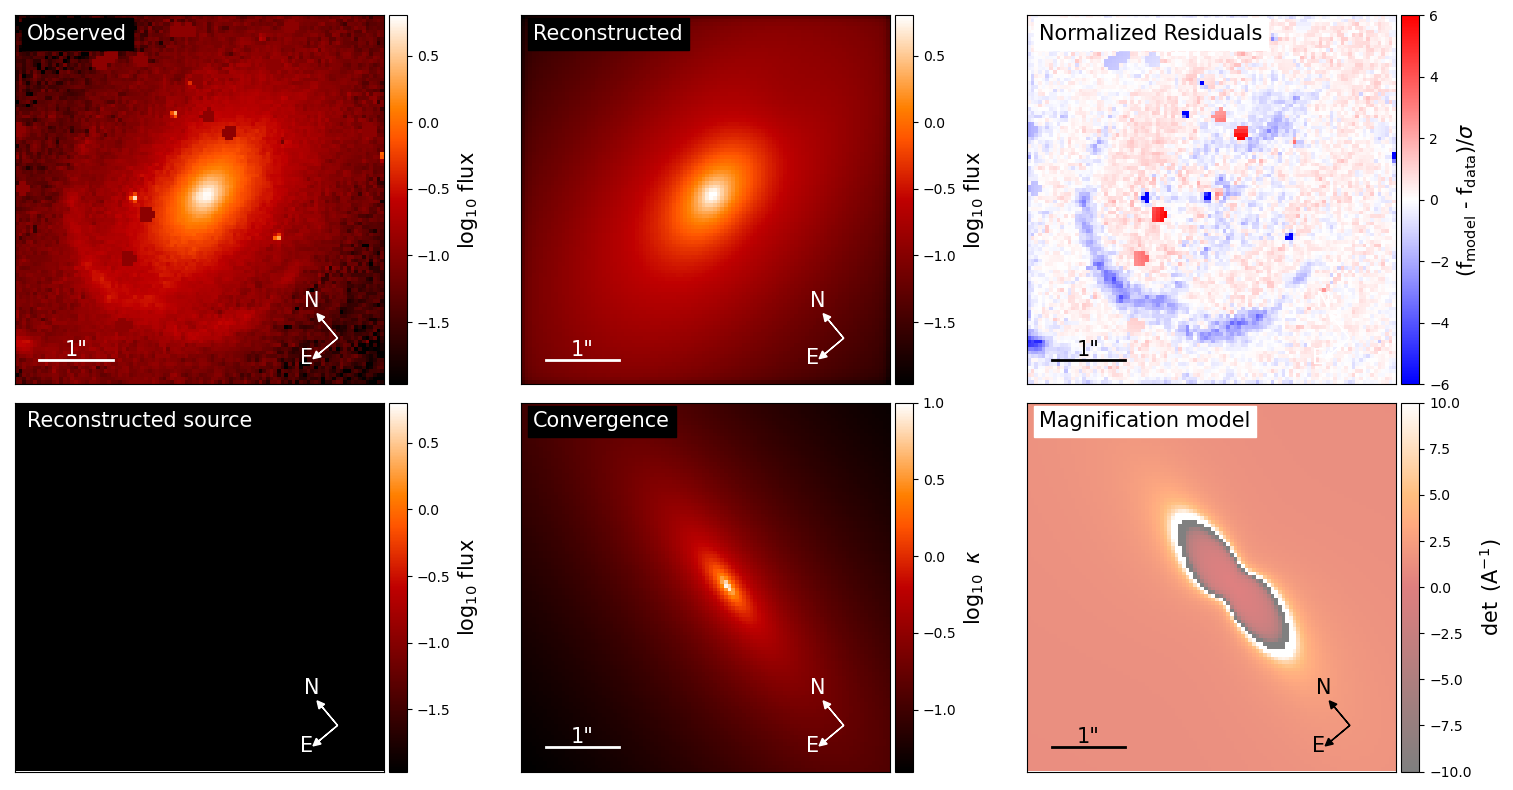

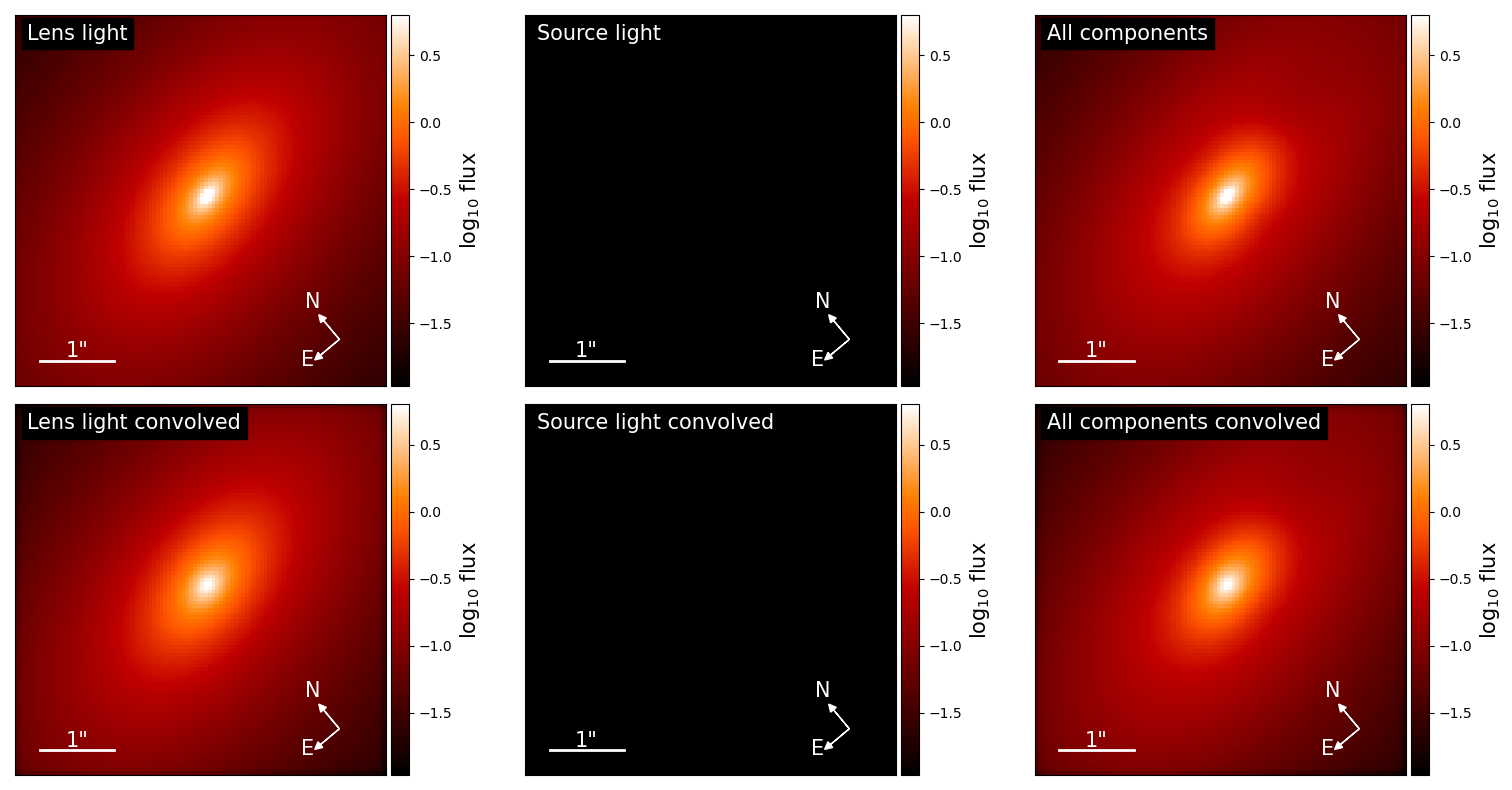

In [ ]:
modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat", linear_solver=kwargs_constraints.get('linear_solver', True))
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='none', sharey='none')

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=pixel_scale, numPix=nx)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
f.show()
f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_p1.png'))

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex='none', sharey='none')

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
f.show()
f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_p2.png'))

number of non-linear parameters in the MCMC process:  19
parameters in order:  ['theta_E_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0', 'R_sersic_lens_light0', 'n_sersic_lens_light0', 'e1_lens_light0', 'e2_lens_light0', 'center_x_lens_light0', 'center_y_lens_light0']
number of evaluations in the MCMC process:  19000
19000


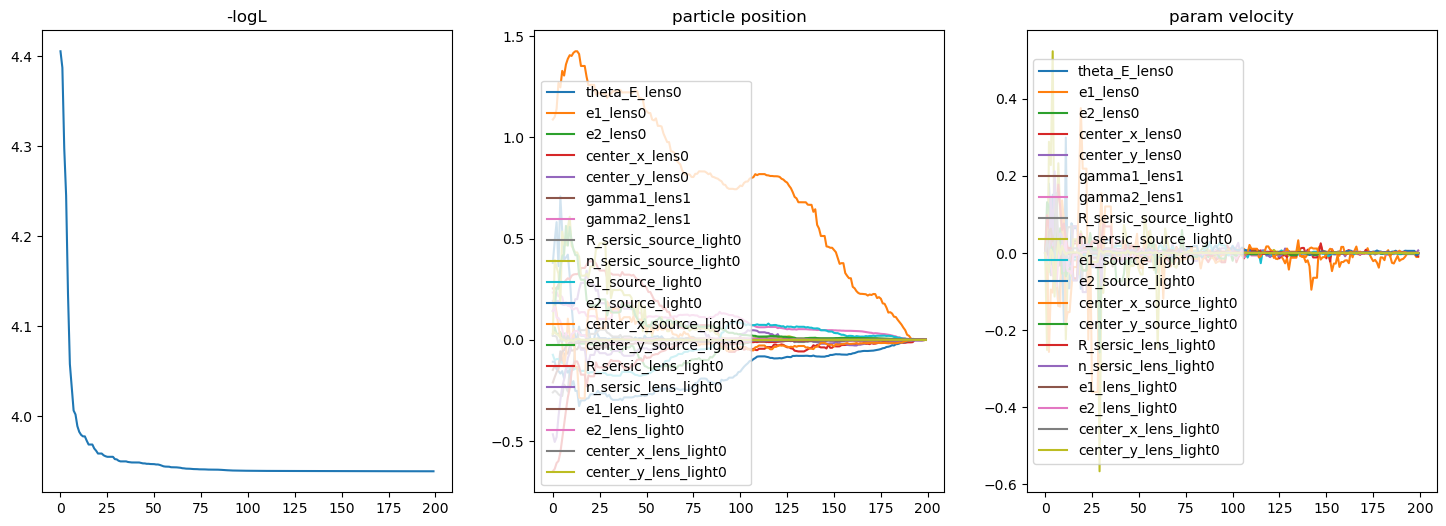

<Figure size 640x480 with 0 Axes>

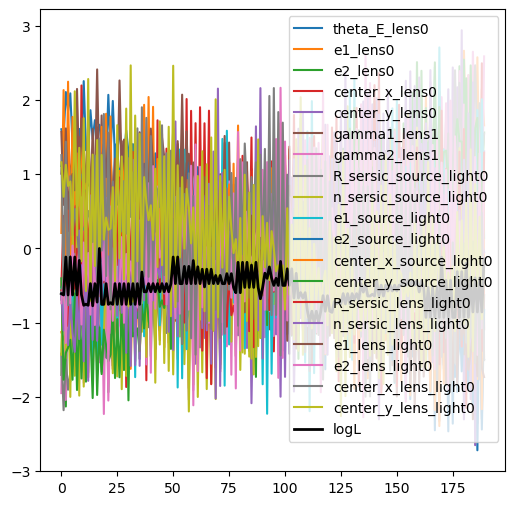

In [ ]:
sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[1]
param_class = fitting_seq.param_class

for i in range(len(chain_list)):
    f, axes = chain_plot.plot_chain_list(chain_list, i)
    f.savefig(os.path.join(repo_path, 'figures', 'lenstronomy_modeling', data_set_name + '_p' + str(i + 3) + '.png'))


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]

Retrieve macrolens parameters from fitting

In [ ]:
pprint(kwargs_result)

kwargs_macromodel_lens = kwargs_result.get('kwargs_lens')
kwargs_macromodel_lens_light = kwargs_result.get('kwargs_lens_light')
kwargs_macromodel_ps = kwargs_result.get('kwargs_ps')
kwargs_macromodel_source = kwargs_result.get('kwargs_source')
kwargs_macromodel_special = kwargs_result.get('kwargs_special')

cache_path = os.path.join(repo_path, 'data', 'cache')

{'kwargs_extinction': [],
 'kwargs_lens': [{'center_x': -0.20709285956798473,
                  'center_y': -0.1772520347806466,
                  'e1': -0.4894985846055906,
                  'e2': -0.06053459553458621,
                  'theta_E': 0.50432086489553},
                 {'dec_0': 0.0,
                  'gamma1': 0.1853222841467135,
                  'gamma2': -0.1981153201887284,
                  'ra_0': 0.0}],
 'kwargs_lens_light': [{'R_sersic': 4.027252903451906,
                        'amp': 12.743941863770107,
                        'center_x': -0.07838191862937202,
                        'center_y': -0.015212676553016861,
                        'e1': 0.2599530098275417,
                        'e2': -0.11378508687913935,
                        'n_sersic': 4.952445650704843}],
 'kwargs_ps': [],
 'kwargs_source': [{'R_sersic': 0.551502287499813,
                    'amp': -29.59938991167828,
                    'center_x': -0.28971731544800833,
                  

Take a look at the fitted macrolens model

In [ ]:
modeled_lenses_dir = os.path.join(repo_path, 'data', 'modeled_lenses')

with open(os.path.join(modeled_lenses_dir, data_set_name + '_lens'), 'ab') as lens_file:
    pickle.dump(kwargs_macromodel_lens, lens_file)

with open(os.path.join(modeled_lenses_dir, data_set_name + '_lens_light'), 'ab') as lens_light_file:
    pickle.dump(kwargs_macromodel_lens_light, lens_light_file)

with open(os.path.join(modeled_lenses_dir, data_set_name + '_source'), 'ab') as source_file:
    pickle.dump(kwargs_macromodel_source, source_file)

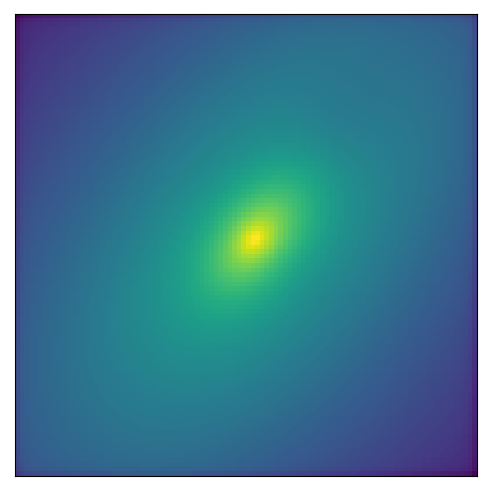

In [ ]:
lens_model_class = LensModel(lens_model_list=lens_model_list)
source_model_class = LightModel(light_model_list=source_model_list)
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_macromodel_lens, kwargs_macromodel_source, kwargs_macromodel_lens_light)

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex='none', sharey='none')
ax = axes
axes.matshow(np.log10(image_sim), origin='lower')
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)
axes.autoscale(False)
plt.show()